Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from datetime import timedelta
from itertools import combinations
from scipy import stats

# Modelling imports
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.model_selection import cross_val_score, LeaveOneOut
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from sklearn.metrics import r2_score

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [ ]:
sns_general_width   = 16
sns_general_height  = 8
sns.set(rc={'figure.figsize':(sns_general_width, sns_general_height)})

## ETL

Utilities

In [ ]:
# Special codes with the exception of Kosovo (OWID_KOS)
special_owid_codes = ('OWID_AFR', 'OWID_ASI', 'OWID_EUR', 'OWID_EUN', 'OWID_HIC',
       'OWID_INT', 'OWID_LIC', 'OWID_LMC', 'OWID_NAM',
       'OWID_CYN', 'OWID_OCE', 'OWID_SAM', 'OWID_UMC', 'OWID_WRL')

In [ ]:
def plot_full(countries, df, title, metric, date="date"):
    for country in countries:
        _df = df[df['country'] == country]
        plt.plot(_df[date], _df[metric])
    plt.title(title)
    plt.ylabel(metric.replace('_', ' ').title())
    plt.xlabel('Time')

def plot_summary(df, title, metric, date='date', remove_mean=False):
    if not remove_mean:
        df = df.groupby(date).agg(
                mean=(metric,"mean"), 
                median=(metric,"median"),
                percentile_5=(metric, lambda x: np.nanpercentile(x, 5)),
                percentile_95=(metric, lambda x: np.nanpercentile(x, 95))
            ).reset_index()
    else:
        df = df.groupby(date).agg(
                median=(metric,"median"),
                percentile_5=(metric, lambda x: np.nanpercentile(x, 5)),
                percentile_95=(metric, lambda x: np.nanpercentile(x, 95))
            ).reset_index()
    df.plot(df.columns[0], df.columns[1:]) # date vs mean, median, 5th, 95th
    plt.title(title)
    plt.ylabel(metric.replace('_', ' ').title())
    plt.xlabel('Time')

### Stringency

In [ ]:
stringency_df = pd.read_csv('data/stringency/covid-stringency-index.csv')
stringency_df.rename(columns={
    "Entity":"country",
    "Code":"code",
    "Day":"date"},
    inplace=True)
    
stringency_df.head()

,country,code,date,stringency_index
0,Afghanistan,AFG,2020-01-21,0.0
1,Afghanistan,AFG,2020-01-22,0.0
2,Afghanistan,AFG,2020-01-23,0.0
3,Afghanistan,AFG,2020-01-24,0.0
4,Afghanistan,AFG,2020-01-25,0.0


In [ ]:
stringency_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138428 entries, 0 to 138427
Data columns (total 4 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   country           138428 non-null  object 
 1   code              138428 non-null  object 
 2   date              138428 non-null  object 
 3   stringency_index  138428 non-null  float64
dtypes: float64(1), object(3)
memory usage: 4.2+ MB


In [ ]:
stringency_df.describe()

,stringency_index
count,138428.000000
mean,52.029399
std,22.729767
min,0.000000
25%,37.960000
50%,52.780000
75%,69.440000
max,100.000000


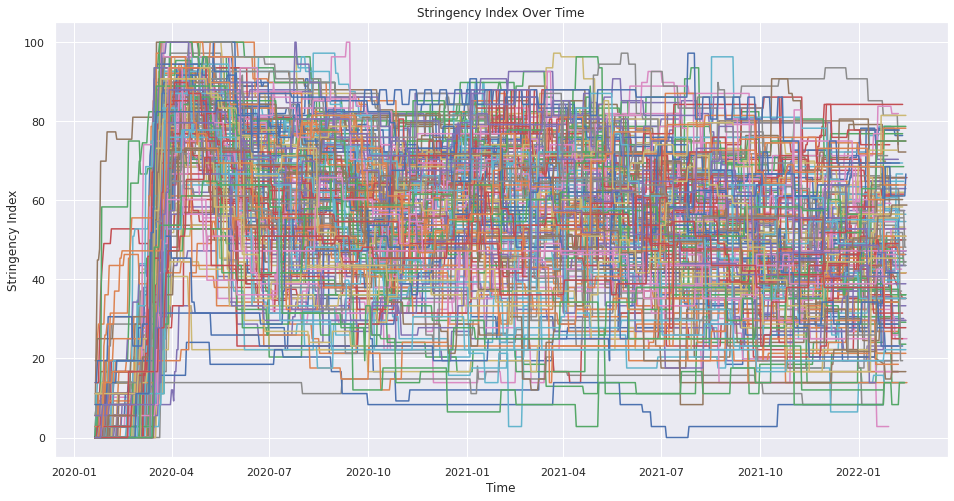

In [ ]:
countries = stringency_df['country'].unique()
stringency_df['date'] = pd.to_datetime(stringency_df['date'])
plot_full(countries, stringency_df, title='Stringency Index Over Time', metric='stringency_index')

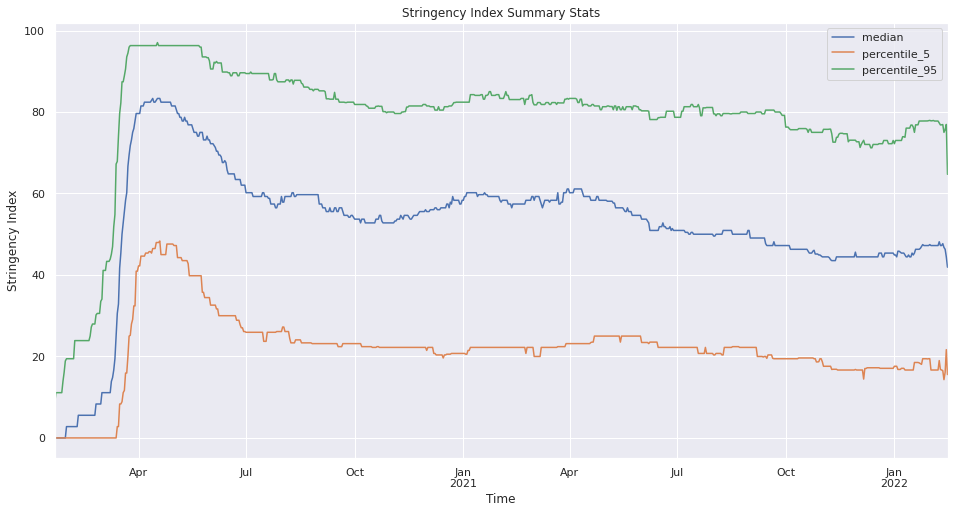

In [ ]:
plot_summary(stringency_df, title='Stringency Index Summary Stats', metric='stringency_index', remove_mean=True)

---
Spot the waves and variants

### Containment/Health

In [ ]:
containment_health_df = pd.read_csv('data/stringency/covid-containment-and-health-index.csv')
containment_health_df.rename(columns={
    "Entity":"country",
    "Code":"code",
    "Day":"date"},
    inplace=True)
containment_health_df.head()

,country,code,date,containment_index
0,Afghanistan,AFG,2020-01-01,0.0
1,Afghanistan,AFG,2020-01-02,0.0
2,Afghanistan,AFG,2020-01-03,0.0
3,Afghanistan,AFG,2020-01-04,0.0
4,Afghanistan,AFG,2020-01-05,0.0


In [ ]:
containment_health_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142001 entries, 0 to 142000
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   country            142001 non-null  object 
 1   code               142001 non-null  object 
 2   date               142001 non-null  object 
 3   containment_index  142001 non-null  float64
dtypes: float64(1), object(3)
memory usage: 4.3+ MB


In [ ]:
containment_health_df.describe()

,containment_index
count,142001.000000
mean,51.150051
std,20.569953
min,0.000000
25%,41.670000
50%,55.360000
75%,66.070000
max,93.450000


In [ ]:
containment_health_df['date'] = pd.to_datetime(containment_health_df['date'])

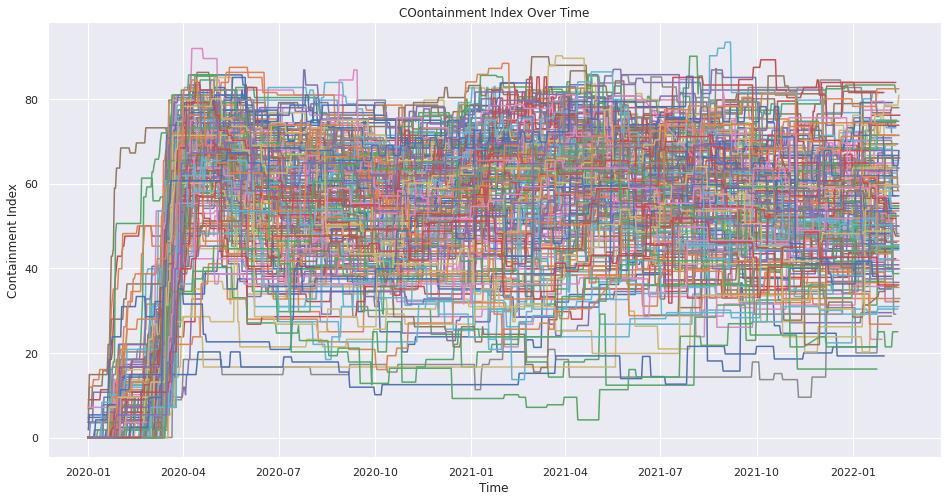

In [ ]:
plot_full(countries, containment_health_df, title='COontainment Index Over Time', metric='containment_index')

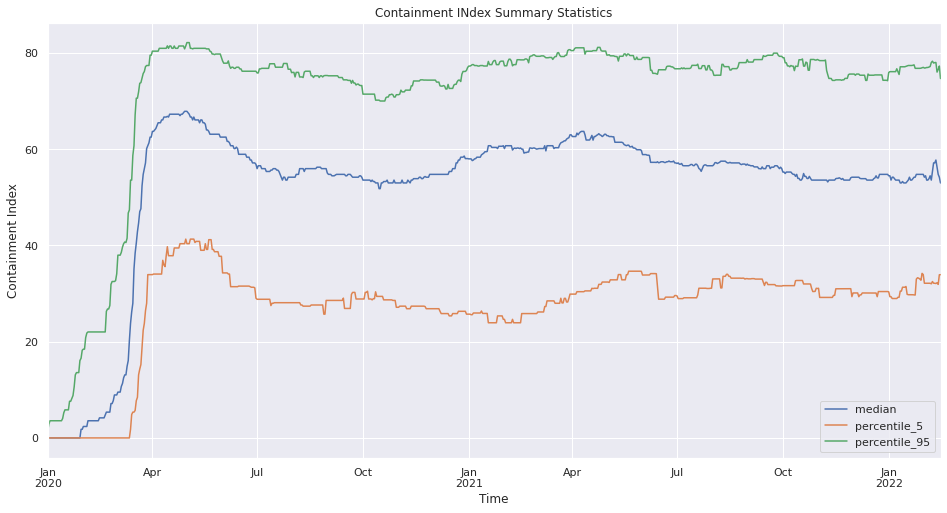

In [ ]:
plot_summary(containment_health_df, title='Containment INdex Summary Statistics', metric='containment_index', remove_mean=True)

Cases, deaths, mobility against Stringency/containment  
Pull in mask data too

### Deaths
Deaths can be an intensity metric

In [ ]:
covid_history_df = pd.read_csv('data/general/owid-covid-data.csv')
covid_history_df.rename(columns={
    "location":"country",
    "iso_code":"code"},
    inplace=True)

owid_aggregations_df = covid_history_df[covid_history_df['code'].isin(special_owid_codes)]
owid_aggregations_df.rename(columns={
    "country":"category"},
    inplace=True)

covid_history_df = covid_history_df[~covid_history_df['code'].isin(special_owid_codes)].sort_values(by=['code', 'date'])
covid_history_df.head()

,code,continent,country,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
7204,ABW,North America,Aruba,2020-03-13,2.0,2.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,76.29,NaN,NaN,NaN,NaN,NaN
7205,ABW,North America,Aruba,2020-03-14,2.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,76.29,NaN,NaN,NaN,NaN,NaN
7206,ABW,North America,Aruba,2020-03-15,2.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,76.29,NaN,NaN,NaN,NaN,NaN
7207,ABW,North America,Aruba,2020-03-16,2.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,76.29,NaN,NaN,NaN,NaN,NaN
7208,ABW,North America,Aruba,2020-03-17,3.0,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,76.29,NaN,NaN,NaN,NaN,NaN


In [ ]:
income_levels = [level for level in owid_aggregations_df["category"].unique() if level.endswith("income")]
income_levels

['High income', 'Low income', 'Lower middle income', 'Upper middle income']

In [ ]:
# remove rows for any country before it makes a contribution to the data
def remove_rows_before_contributions():
    for code in covid_history_df.code.unique():
        _df = covid_history_df[covid_history_df['code'] == code]
        for row in _df.itertuples():
            if (row.new_cases == 0 or row.new_cases is None) and (row.total_cases == 0 or row.total_cases is None):
                covid_history_df.drop(index=row.Index, inplace=True)
                break
        continue
remove_rows_before_contributions()

In [ ]:
covid_history_df.describe()

,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
count,1.494710e+05,1.494310e+05,148357.000000,131999.000000,131974.000000,131916.000000,149471.000000,149431.000000,148357.000000,131999.000000,...,102636.000000,101217.000000,66076.000000,119818.000000,150598.000000,132065.000000,5.520000e+03,5520.000000,5532.000000,5520.000000
mean,6.091378e+05,2.768952e+03,2750.026014,14392.874332,44.023565,43.808731,27436.963204,157.789241,155.576963,489.620358,...,10.661957,32.757015,50.677561,3.030285,73.582626,0.725585,3.685615e+04,9.213859,15.987232,924.226535
std,3.036980e+06,1.768855e+04,16699.080456,57807.687560,194.868409,183.471101,47135.931057,665.961036,507.182242,769.256198,...,10.593430,13.568759,31.974186,2.458626,7.511894,0.150416,1.027585e+05,16.497870,30.375823,1373.111371
min,1.000000e+00,-7.493700e+04,-6223.000000,1.000000,-1918.000000,-232.143000,0.001000,-13876.282000,-1936.106000,0.001000,...,0.100000,7.700000,1.188000,0.100000,53.280000,0.394000,-3.772610e+04,-28.450000,-95.920000,-1826.595723
25%,1.613000e+03,0.000000e+00,5.714000,68.000000,0.000000,0.143000,553.505500,0.000000,1.429000,16.556000,...,1.900000,21.600000,19.351000,1.300000,69.020000,0.602000,-8.922500e+01,-0.890000,-0.830000,-37.027419
50%,1.902600e+04,6.000000e+01,82.571000,610.000000,1.000000,1.857000,4332.005000,9.724000,16.433000,113.443000,...,6.300000,31.400000,49.542000,2.397000,75.050000,0.744000,3.217500e+03,5.755000,7.130000,436.789598
75%,2.167640e+05,7.420000e+02,795.429000,5047.000000,13.000000,14.000000,35257.099000,96.151500,113.788000,672.234000,...,19.300000,41.300000,83.241000,4.000000,78.950000,0.845000,2.413720e+04,14.300000,22.947500,1578.960127
max,7.803635e+07,1.368563e+06,802374.000000,925435.000000,4529.000000,4190.000000,611787.251000,51427.491000,16052.608000,6249.090000,...,44.000000,78.100000,100.000000,13.800000,86.750000,0.957000,1.080748e+06,111.010000,374.600000,8626.892312


In [ ]:
covid_history_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 152105 entries, 7204 to 162143
Data columns (total 67 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   code                                        152105 non-null  object 
 1   continent                                   152105 non-null  object 
 2   country                                     152105 non-null  object 
 3   date                                        152105 non-null  object 
 4   total_cases                                 149471 non-null  float64
 5   new_cases                                   149431 non-null  float64
 6   new_cases_smoothed                          148357 non-null  float64
 7   total_deaths                                131999 non-null  float64
 8   new_deaths                                  131974 non-null  float64
 9   new_deaths_smoothed                         131916 non-null  float6

Deaths per million

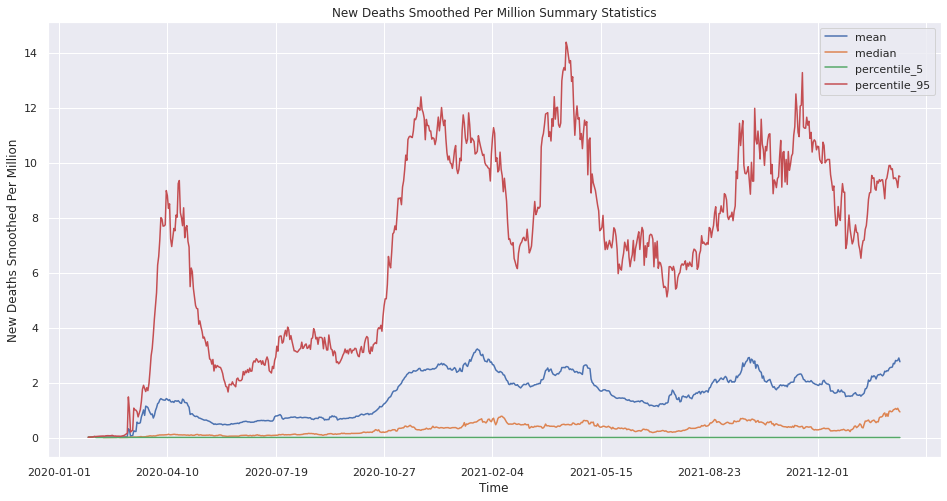

In [ ]:
plot_summary(covid_history_df, title='New Deaths Smoothed Per Million Summary Statistics', metric="new_deaths_smoothed_per_million")

Mortality

In [ ]:
# Align the zeros of the two y-axes
# Adapted from: https://stackoverflow.com/a/54355867/6712832
def align_yaxis(ax1, ax2):
    y_lims = np.array([ax.get_ylim() for ax in [ax1, ax2]])

    # force 0 to appear on both axes, comment if don't need
    y_lims[:, 0] = y_lims[:, 0].clip(None, 0)
    y_lims[:, 1] = y_lims[:, 1].clip(0, None)

    # normalize both axes
    y_mags = (y_lims[:,1] - y_lims[:,0]).reshape(len(y_lims),1)
    y_lims_normalized = y_lims / y_mags

    # find combined range
    y_new_lims_normalized = np.array([np.min(y_lims_normalized), np.max(y_lims_normalized)])

    # denormalize combined range to get new axes
    new_lim1, new_lim2 = y_new_lims_normalized * y_mags
    ax1.set_ylim(new_lim1)
    ax2.set_ylim(new_lim2)

(0.0, 75.0)

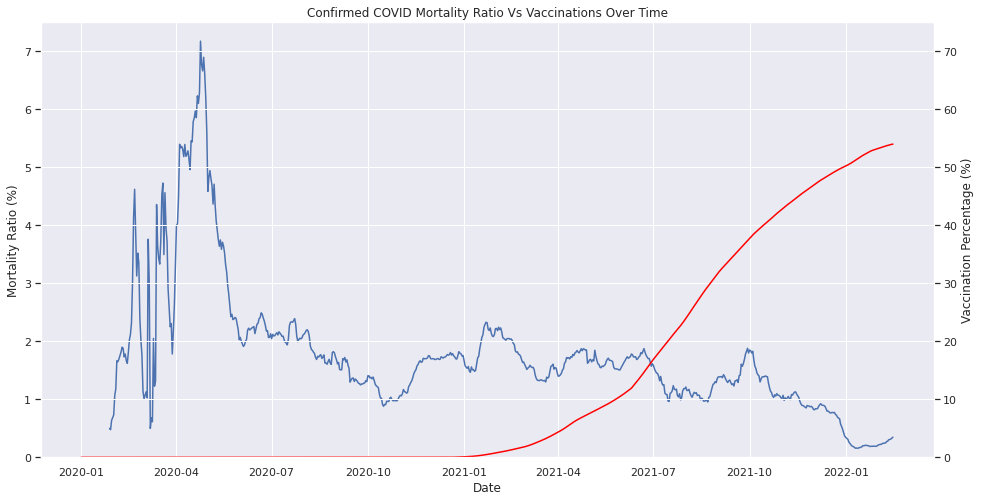

In [ ]:
mortality_df = covid_history_df.groupby('date').agg('sum').reset_index()
mortality_df['date'] = pd.to_datetime(mortality_df['date'])
fig, ax = plt.subplots()

ax.plot(mortality_df['date'], 100*mortality_df['new_deaths_smoothed_per_million']/mortality_df['new_cases_smoothed_per_million'], label='Mortality Ratio')
ax.set_title('Confirmed COVID Mortality Ratio Vs Vaccinations Over Time')
ax.set_ylabel('Mortality Ratio (%)')
ax.set_xlabel('Date')

ax_twin = ax.twinx()
ax_twin.plot(mortality_df['date'], 100*np.cumsum(mortality_df['new_people_vaccinated_smoothed'])/mortality_df['population'], color='red', label='Vaccination Percentage')

ax_twin.set_ylabel('Vaccination Percentage (%)')
# align_yaxis(ax, ax_twin)
ax.set_ylim([0, 7.5])
ax_twin.set_ylim([0, 75])

# Standard error froo mortality ratio. Formula here: https://www.statology.org/standard-error-of-proportion/


In [ ]:
selected_columns = [col for col in covid_history_df.columns if (
                ("_per_" in col or "smoothed" in col) and ("cases" in col or "deaths" in col) and ("total" not in col)
                )]+['stringency_index']

### Mobility

In [ ]:
mobility_df = pd.read_csv("data/mobility/changes-visitors-covid.csv")
mobility_df.rename(columns={
    "Entity":"country",
    "Code":"code",
    "Day":"date"},
    inplace=True)
merged_df = pd.merge(covid_history_df, mobility_df, how="outer", on=["country", "code", "date"])

In [ ]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 155412 entries, 0 to 155411
Data columns (total 73 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   code                                        155412 non-null  object 
 1   continent                                   152105 non-null  object 
 2   country                                     155412 non-null  object 
 3   date                                        155412 non-null  object 
 4   total_cases                                 149471 non-null  float64
 5   new_cases                                   149431 non-null  float64
 6   new_cases_smoothed                          148357 non-null  float64
 7   total_deaths                                131999 non-null  float64
 8   new_deaths                                  131974 non-null  float64
 9   new_deaths_smoothed                         131916 non-null  float64
 

In [ ]:
# Making sure that stringency_index stays at the end of the column list after adding mobility
selected_columns = selected_columns[:-1] + list(merged_df.columns[-6:]) + ['stringency_index']

Change in correlations over time

In [ ]:
selected_columns

['new_cases_smoothed',
 'new_deaths_smoothed',
 'new_cases_per_million',
 'new_cases_smoothed_per_million',
 'new_deaths_per_million',
 'new_deaths_smoothed_per_million',
 'retail_and_recreation',
 'grocery_and_pharmacy',
 'residential',
 'transit_stations',
 'parks',
 'workplaces',
 'stringency_index']

In [ ]:
max(merged_df['date'])

'2022-02-15'

North America
South America
Asia
Europe
Oceania
Africa


Text(0, 0.5, 'Correlation of Residential Mobility and Stringency Index')

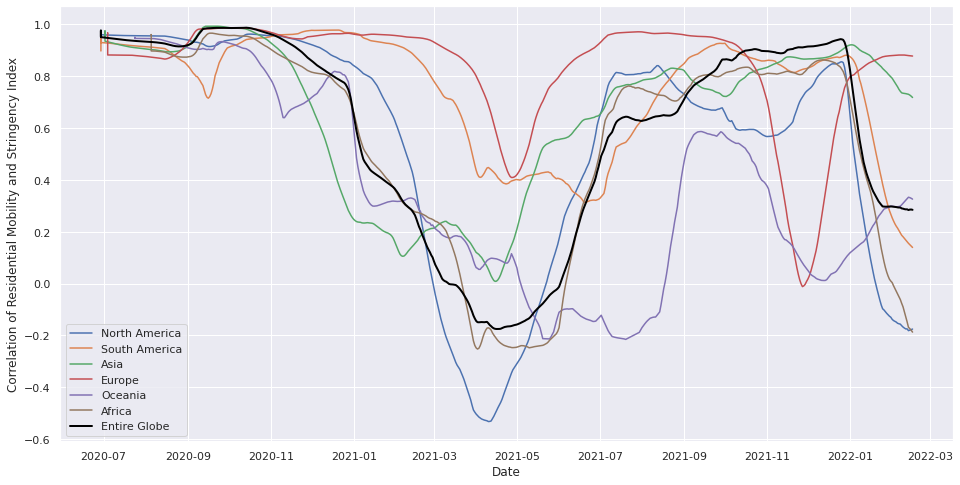

In [ ]:
# df_for_windows = merged_df[merged_df['country'] == 'United States'][['date']+selected_columns[-7:]]
df_for_windows = merged_df[['date', 'continent', 'residential', 'stringency_index']]
df_for_windows['date'] = pd.to_datetime(df_for_windows['date'])

rolling_window = 180 # Averaging window of 6 months
panic_window = 90 # The first 3 months of data from Jan to March involve a lot of panic, this can throw our analysis off.

df_for_windows = df_for_windows.groupby(['date', 'continent']).agg('mean').reset_index()

for continent in df_for_windows['continent'].unique():
    residential_corr = []
    end_dates = []
    if continent not in ['0', 0]:
        print(continent) # a weird zero pops up during the aggregation... probably due to aggregations done at OWID level
        for window in df_for_windows[df_for_windows['continent']==continent].rolling(window=rolling_window):
            # if len(window) > 0:
            residential_corr.append(window[['residential','stringency_index']].corr()['stringency_index'][0])
            end_dates.append(window['date'].iloc[0] + timedelta(days=rolling_window))
        plt.plot(end_dates[panic_window:], residential_corr[panic_window:], label=continent)
        
residential_corr = []
end_dates = []
df_for_windows = df_for_windows[['date', 'residential', 'stringency_index']].groupby(['date']).agg('mean').reset_index()
for window in df_for_windows.rolling(window=rolling_window):
    # if len(window) > 0:
    residential_corr.append(window[['residential','stringency_index']].corr()['stringency_index'][0])
    end_dates.append(list(window['date'])[0] + timedelta(days=rolling_window))
plt.plot(end_dates[panic_window:], residential_corr[panic_window:], label="Entire Globe", color="black", linewidth=2)
plt.legend()
plt.xlabel("Date")
plt.ylabel("Correlation of Residential Mobility and Stringency Index")

In [ ]:
covid_history_df[covid_history_df['country'] == 'United States']

,code,continent,country,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
153274,USA,North America,United States,2020-01-22,1.0,NaN,NaN,NaN,NaN,NaN,...,19.1,24.6,NaN,2.77,78.86,0.926,NaN,NaN,NaN,NaN
153275,USA,North America,United States,2020-01-23,1.0,0.0,NaN,NaN,NaN,NaN,...,19.1,24.6,NaN,2.77,78.86,0.926,NaN,NaN,NaN,NaN
153276,USA,North America,United States,2020-01-24,2.0,1.0,NaN,NaN,NaN,NaN,...,19.1,24.6,NaN,2.77,78.86,0.926,NaN,NaN,NaN,NaN
153277,USA,North America,United States,2020-01-25,2.0,0.0,NaN,NaN,NaN,NaN,...,19.1,24.6,NaN,2.77,78.86,0.926,NaN,NaN,NaN,NaN
153278,USA,North America,United States,2020-01-26,5.0,3.0,NaN,NaN,NaN,NaN,...,19.1,24.6,NaN,2.77,78.86,0.926,-8925.0,-3.59,-2.63,-26.808639
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154025,USA,North America,United States,2022-02-11,77650446.0,209265.0,187509.143,918818.0,2604.0,2338.286,...,19.1,24.6,NaN,2.77,78.86,0.926,NaN,NaN,NaN,NaN
154026,USA,North America,United States,2022-02-12,77705598.0,55152.0,180461.429,919622.0,804.0,2324.286,...,19.1,24.6,NaN,2.77,78.86,0.926,NaN,NaN,NaN,NaN
154027,USA,North America,United States,2022-02-13,77762374.0,56776.0,177070.714,920063.0,441.0,2331.000,...,19.1,24.6,NaN,2.77,78.86,0.926,NaN,NaN,NaN,NaN
154028,USA,North America,United States,2022-02-14,77925899.0,163525.0,152034.429,922840.0,2777.0,2309.857,...,19.1,24.6,NaN,2.77,78.86,0.926,NaN,NaN,NaN,NaN


Optimizing lag

In [ ]:
greatest_abs_corr = 0
for lag in range(0,90):
    _corr = merged_df['stringency_index'].corr(merged_df['residential'].shift(lag))
    # print(_corr)
    if abs(_corr) > greatest_abs_corr:
        greatest_abs_corr = abs(_corr)
        print(f"{lag} days lag: {_corr}")

0 days lag: 0.5752429268395908


In [ ]:
# OPtimizing lag on a country by country basis would look like this:
greatest_abs_corr = 0
for lag in range(0,90):
    _corr = merged_df[merged_df['country'] == 'United Kingdom']['stringency_index'].corr(merged_df[merged_df['country'] == 'United Kingdom']['residential'].shift(lag))
    # print(_corr)
    if abs(_corr) > greatest_abs_corr:
        greatest_abs_corr = abs(_corr)
        print(f"{lag} days lag: {_corr}")

0 days lag: 0.8181370757644617


#### Stringency Vs Deaths

#### Stringency Vs Cases

#### Stringency Vs Mobility

### Mobility vs Deaths

---


### Q1. Headline
* Mean of new deaths smoothed per million (show units on twin axis) - virus snapshot
* Mortality ratio (Derived from cases and deaths) - how deadly is it?
* Stringency over time  - how are governments responding?
* Mobility over time - how are people reacting?


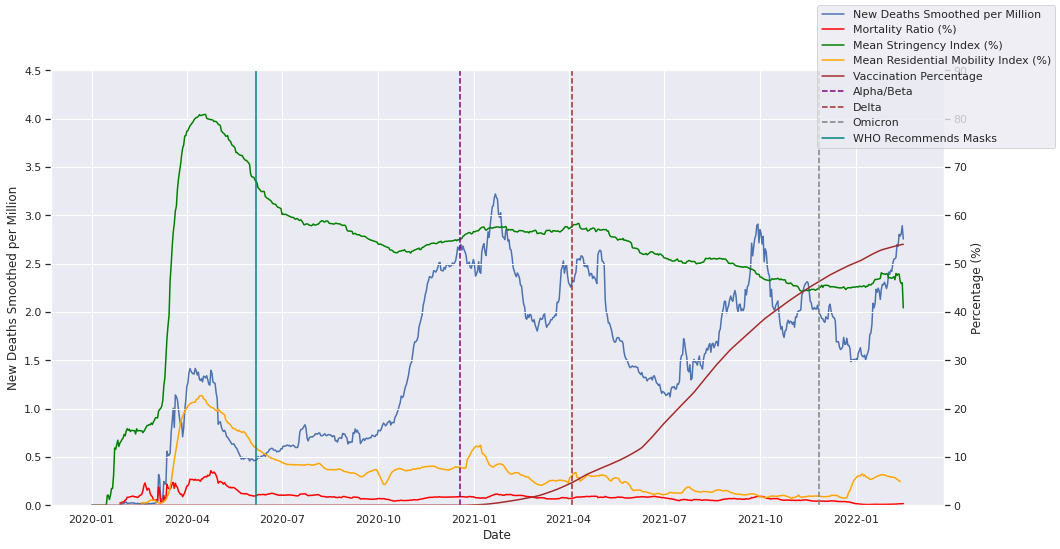

In [ ]:
date_sum_df = merged_df.groupby('date').agg('sum').reset_index()
date_mean_df = merged_df.groupby('date').agg('mean').reset_index()

date_sum_df['date'] = pd.to_datetime(date_sum_df['date'])
date_mean_df['date'] = pd.to_datetime(date_mean_df['date'])

fig, ax = plt.subplots()

# Mean of new deaths smoothed per million (show units on twin axis) - virus snapshot
ax.plot(date_mean_df['date'], date_mean_df['new_deaths_smoothed_per_million'], label='New Deaths Smoothed per Million')
ax.set_ylabel('New Deaths Smoothed per Million')
ax.set_xlabel('Date')

# Mortality ratio (Derived from cases and deaths) - how deadly is it?
ax_twin_percentages = ax.twinx()
ax_twin_percentages.plot(date_sum_df['date'], 100*date_sum_df['new_deaths_smoothed_per_million']/date_sum_df['new_cases_smoothed_per_million'], label='Mortality Ratio (%)', color='red')
ax_twin_percentages.set_ylabel('Percentage (%)')

# Stringency over time  - how are governments responding?
ax_twin_percentages.plot(date_mean_df['date'], date_mean_df['stringency_index'], label='Mean Stringency Index (%)', color='green')

ax_twin_percentages.plot(date_mean_df['date'], date_mean_df['residential'], label='Mean Residential Mobility Index (%)', color='orange')

ax_twin_percentages.plot(date_sum_df['date'], 100*np.cumsum(date_sum_df['new_people_vaccinated_smoothed'])/date_sum_df['population'], color='brown', label='Vaccination Percentage')

ax.set_ylim(0, 4.5)
ax_twin_percentages.set_ylim(0, 90)

# Variant lines. Dates the variants were declared variants of concern.
# Accroding to: https://www.who.int/en/activities/tracking-SARS-CoV-2-variants/
ax_twin_percentages.axvline(x='2020-12-18', linestyle='--', label='Alpha/Beta', color='purple')
ax_twin_percentages.axvline(x='2021-04-04', linestyle='--', label='Delta', color='brown')
ax_twin_percentages.axvline(x='2021-11-26', linestyle='--', label='Omicron', color='gray')
ax_twin_percentages.axvline(x='2020-06-06', label='WHO Recommends Masks', color='teal')
fig.legend()

### Q2. Effectiveness of disaggregated measures:
a. Masks  
b. Vaccinations  
c. Lockdowns  
d. School closure  

In [ ]:
face_coverings_df = pd.read_csv('data/face_coverings/face-covering-policies-covid.csv')[['Entity', 'Day', 'facial_coverings']]
face_coverings_df.rename(columns={
    "Entity":"country",
    "Day":"date"},
    inplace=True)

merged_df = pd.merge(merged_df, face_coverings_df, on=['country', 'date'], how='left')

In [ ]:
lockdowns_df = pd.read_csv('data/lockdowns/stay-at-home-covid.csv')[['Entity', 'Day', 'stay_home_requirements']]
lockdowns_df.rename(columns={
    "Entity":"country",
    "Day":"date"},
    inplace=True)

merged_df = pd.merge(merged_df, lockdowns_df, on=['country', 'date'], how='left')

In [ ]:
school_closure_df = pd.read_csv('data/school_closure/school-closures-covid.csv')[['Entity', 'Day', 'school_closures']]
school_closure_df.rename(columns={
    "Entity":"country",
    "Day":"date"},
    inplace=True)

merged_df = pd.merge(merged_df, school_closure_df, on=['country', 'date'], how='left')

In [ ]:
workplace_closure_df = pd.read_csv('data/workplace_closure/workplace-closures-covid.csv')[['Entity', 'Day', 'workplace_closures']]
workplace_closure_df.rename(columns={
    "Entity":"country",
    "Day":"date"},
    inplace=True)

merged_df = pd.merge(merged_df, workplace_closure_df, on=['country', 'date'], how='left')

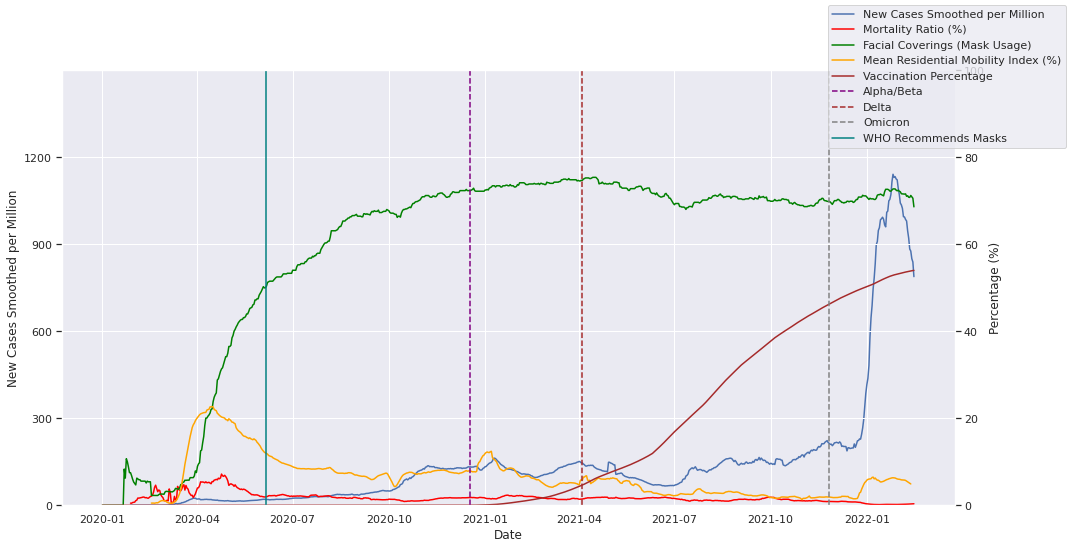

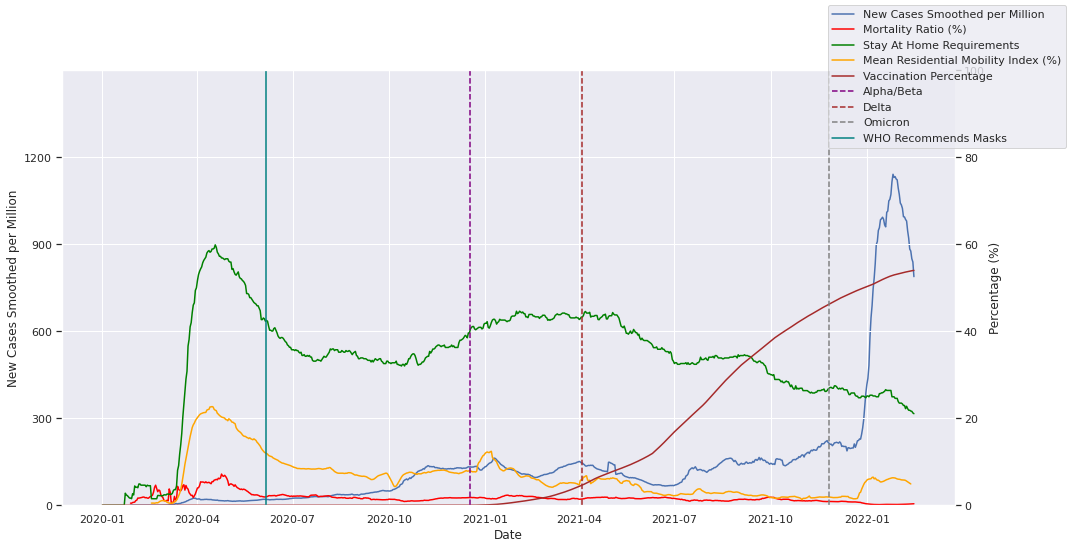

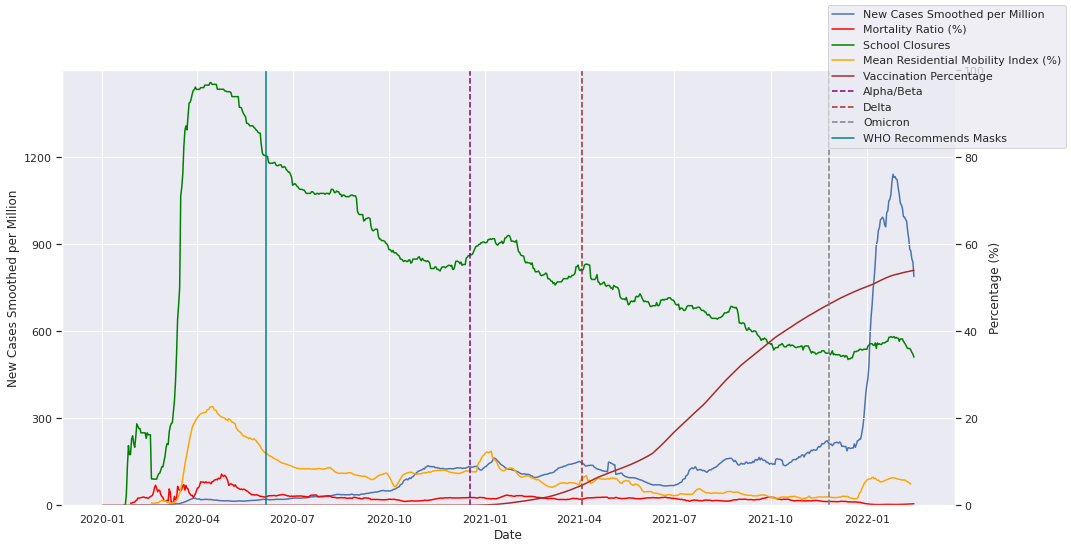

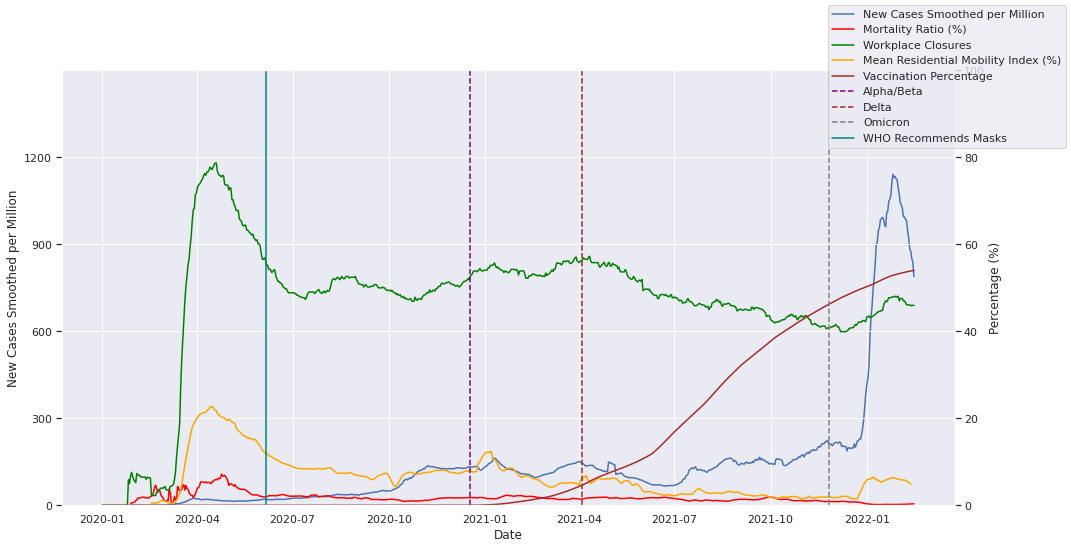

In [ ]:
feature_labels = {
    'facial_coverings': 'Facial Coverings (Mask Usage)',
    'stay_home_requirements': 'Stay At Home Requirements',
    'school_closures': 'School Closures',
    'workplace_closures': 'Workplace Closures'
}
for feature in merged_df.columns[-4:]:
    merged_df[feature] = 100 * merged_df[feature]/max(merged_df[feature])
    # Sum features need to be summed in aggregation
    # Others need to be averaged in aggregation
    date_sum_df = merged_df.groupby('date').agg('sum').reset_index()
    date_mean_df = merged_df.groupby('date').agg('mean').reset_index()

    date_sum_df['date'] = pd.to_datetime(date_sum_df['date'])
    date_mean_df['date'] = pd.to_datetime(date_mean_df['date'])

    fig, ax = plt.subplots()

    # Mean of new deaths smoothed per million (show units on twin axis) - virus snapshot
    ax.plot(date_mean_df['date'], date_mean_df['new_cases_smoothed_per_million'], label='New Cases Smoothed per Million')
    ax.set_ylabel('New Cases Smoothed per Million')
    ax.set_xlabel('Date')

    # Mortality ratio (Derived from cases and deaths) - how deadly is it?
    ax_twin_percentages = ax.twinx()
    ax_twin_percentages.plot(date_sum_df['date'], 100*date_sum_df['new_deaths_smoothed_per_million']/date_sum_df['new_cases_smoothed_per_million'], label='Mortality Ratio (%)', color='red')
    ax_twin_percentages.set_ylabel('Percentage (%)')

    # Stringency over time  - how are governments responding?
    ax_twin_percentages.plot(date_mean_df['date'], date_mean_df[feature], label=feature_labels[feature], color='green')

    ax_twin_percentages.plot(date_mean_df['date'], date_mean_df['residential'], label='Mean Residential Mobility Index (%)', color='orange')

    ax_twin_percentages.plot(date_sum_df['date'], 100*np.cumsum(date_sum_df['new_people_vaccinated_smoothed'])/date_sum_df['population'], color='brown', label='Vaccination Percentage')

    ax.set_ylim(0, 1500)
    ax.yaxis.set_ticks(np.arange(0, 1500, 300))
    ax_twin_percentages.set_ylim(0, 100)

    # Variant lines. Dates the variants were declared variants of concern.
    # Accroding to: https://www.who.int/en/activities/tracking-SARS-CoV-2-variants/
    ax_twin_percentages.axvline(x='2020-12-18', linestyle='--', label='Alpha/Beta', color='purple')
    ax_twin_percentages.axvline(x='2021-04-04', linestyle='--', label='Delta', color='brown')
    ax_twin_percentages.axvline(x='2021-11-26', linestyle='--', label='Omicron', color='gray')
    ax_twin_percentages.axvline(x='2020-06-06', label='WHO Recommends Masks', color='teal')

    fig.legend()
    plt.show()

### Q3. Influences of socioeconomic & demographic factors on compliance

In [ ]:
# Read in socioeconomic factors

# literacy
literacy_df = pd.read_csv('data/education/literacy-rate-by-country.csv')[[
    'Entity', 'Literacy rate (CIA Factbook (2016))'
    ]]
literacy_df.rename(columns={
    "Entity":"country",
    "Literacy rate (CIA Factbook (2016))":"literacy_rate"},
    inplace=True)

# Corruption perception
corruption_df = pd.read_csv('data/corruption/TI-corruption-perception-index.csv')[[
    'Entity', 'Corruption Perception Index - Transparency International (2018)', 'Year'
    ]]
corruption_df.rename(columns={
    "Entity":"country",
    "Corruption Perception Index - Transparency International (2018)":"corruption_index"},
    inplace=True)
corruption_df = corruption_df.groupby('country').last().reset_index().drop(columns=['Year'])

# Freedom of expression
expression_df = pd.read_csv('data/freedom_of_expression/freedom-of-expression.csv')[[
    'Entity', 'freeexpr_vdem_owid', 'Year'
    ]]
expression_df.rename(columns={
    "Entity":"country",
    "freeexpr_vdem_owid":"freedom_of_expression"},
    inplace=True)
expression_df = expression_df.groupby('country').last().reset_index().drop(columns=['Year'])

In [ ]:
def get_compliance_df(start_date=None, end_date=None):
    if start_date is not None and end_date is not None:
        sub_df = merged_df[merged_df['date'] <= end_date]
        sub_df = sub_df[sub_df['date'] >= start_date]
    elif start_date is not None:
        sub_df = merged_df[merged_df['date'] >= start_date]
    elif end_date is not None:
        sub_df = merged_df[merged_df['date'] <= end_date]
    else:
        sub_df = merged_df

    row_list = []
    tiny_population_countries = []
    for country in countries:
        # remove countries with populations less than 500,000
        if np.mean(sub_df[sub_df['country'] == country]['population']) < 500000:
            tiny_population_countries.append((country, np.mean(sub_df[sub_df['country'] == country]['population'])))
            continue
        row_list.append((
            country,
            np.mean(sub_df[sub_df['country'] == country]['gdp_per_capita']),
            np.mean(sub_df[sub_df['country'] == country]['life_expectancy']),
            np.mean(sub_df[sub_df['country'] == country]['human_development_index']),\
            np.mean(sub_df[sub_df['country'] == country]['median_age']),
            sub_df[sub_df['country'] == country]['stringency_index'].corr(sub_df[sub_df['country'] == country]['residential'])
        ))
    compliance_df = pd.DataFrame(row_list, columns=['country', 'gdp_per_capita', 'life_expectancy', 'human_development_index', 'median_age', 'compilance'])
    compliance_df = compliance_df.merge(literacy_df, on='country', how='left')
    compliance_df = compliance_df.merge(corruption_df, on='country', how='left')
    compliance_df = compliance_df.merge(expression_df, on='country', how='left')
    compliance_df = compliance_df.dropna()
    return compliance_df, tiny_population_countries
    
compliance_df, tiny_population_countries = get_compliance_df('2020-04-01', '2020-12-31')

In [ ]:
tiny_population_countries

[('Andorra', 77354.0),
 ('Aruba', 107195.0),
 ('Bahamas', 396914.0),
 ('Barbados', 287708.0),
 ('Belize', 404915.0),
 ('Bermuda', 62092.0),
 ('Brunei', 441532.0),
 ('Dominica', 72172.0),
 ('Faeroe Islands', 49053.0),
 ('Greenland', 56868.0),
 ('Iceland', 368792.0),
 ('Liechtenstein', 38254.0),
 ('Monaco', 39520.0),
 ('San Marino', 34010.0),
 ('Seychelles', 98910.0),
 ('Vanuatu', 314464.0)]

<AxesSubplot:>

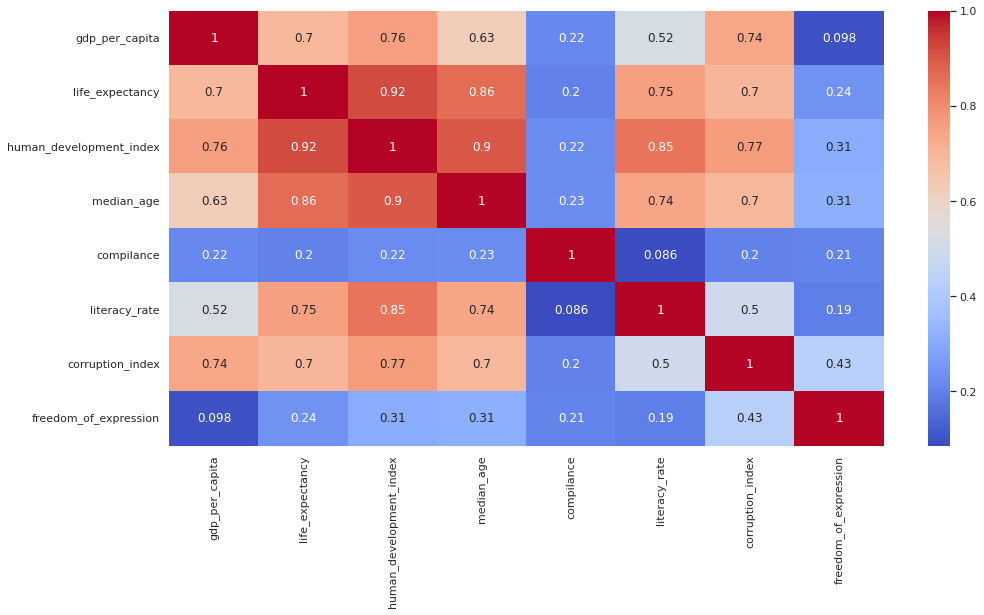

In [ ]:
sns.heatmap(compliance_df.corr(), annot=True, cmap='coolwarm')

Locate outliers here

In [ ]:
compliance_df.columns

Index(['country', 'gdp_per_capita', 'life_expectancy',
       'human_development_index', 'median_age', 'compilance', 'literacy_rate',
       'corruption_index', 'freedom_of_expression'],
      dtype='object')

In [ ]:
# Calculate logs and squares and replot graph below

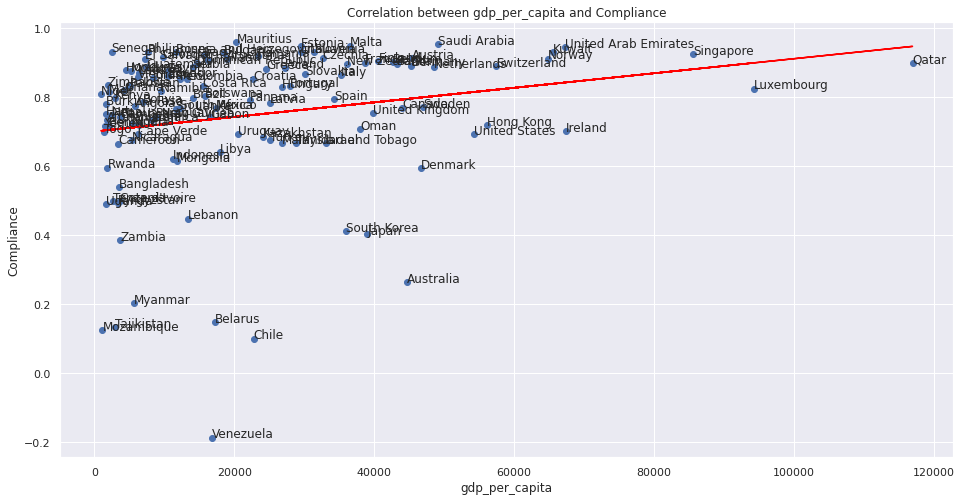

0.21674353181599612


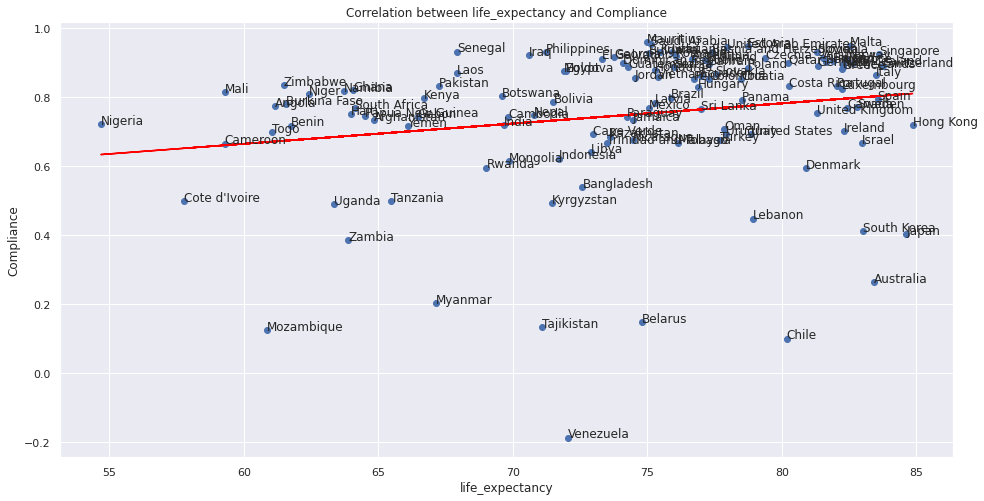

0.20127135326540485


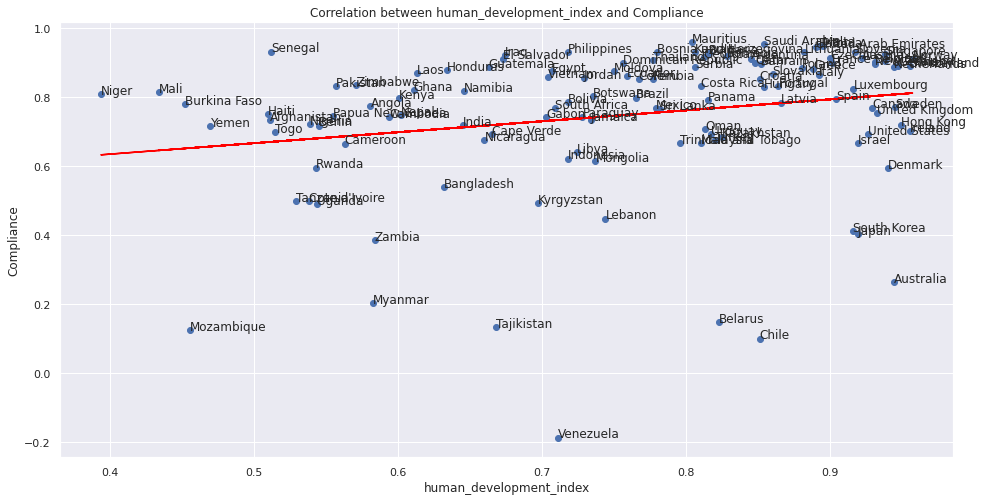

0.22441886748811368


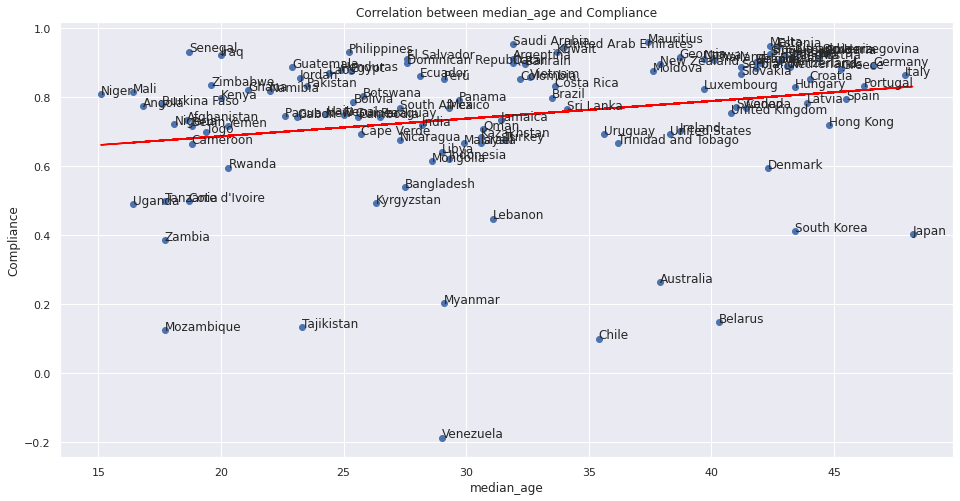

0.2285708925895772


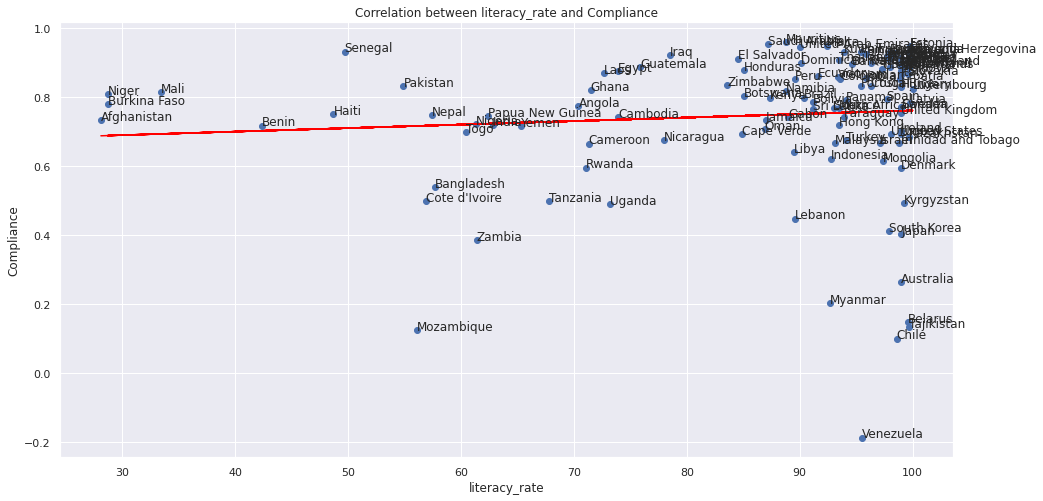

0.08629718540125696


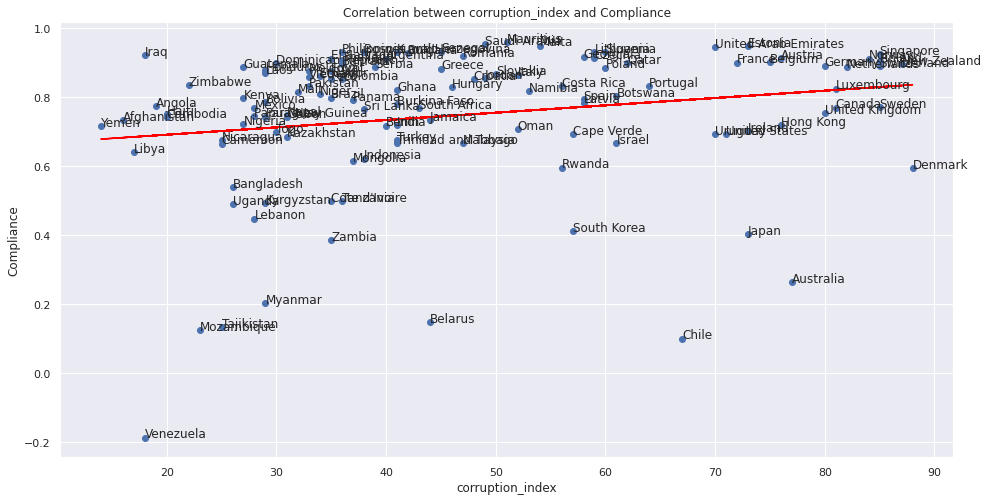

0.2019938408783414


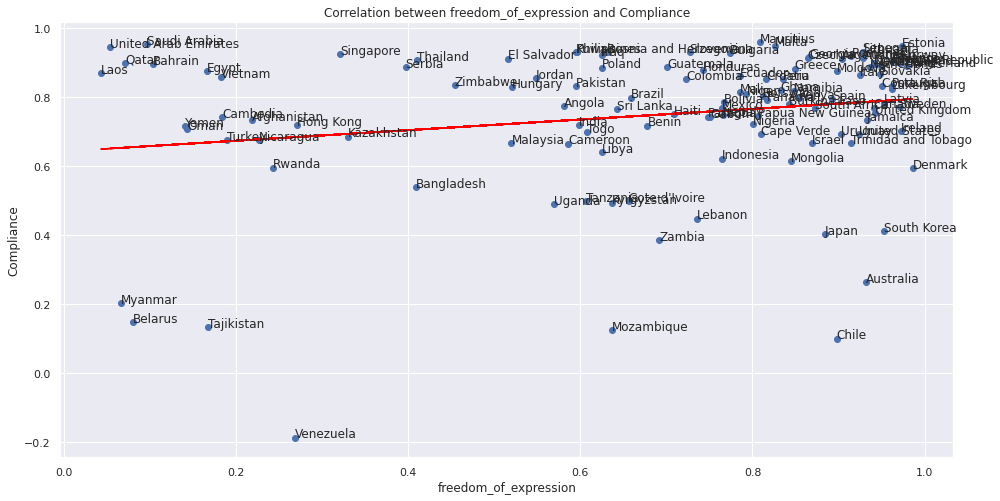

0.2052458455438496


In [ ]:
for feature in ['gdp_per_capita', 'life_expectancy',
       'human_development_index', 'median_age', 'literacy_rate',
       'corruption_index', 'freedom_of_expression']:
    x = compliance_df[feature]
    y = compliance_df['compilance']
    plt.scatter(x, y)
    a, b = np.polyfit(x, y, 1)
    plt.plot(x, a*x+b, color='red')
    plt.title('Correlation between {} and Compliance'.format(feature))
    plt.xlabel(feature)
    plt.ylabel('Compliance')

    for i, txt in zip(compliance_df.index, compliance_df['country']):
        plt.annotate(txt, (x[i], y[i]))
    plt.show()
    print(x.corr(y))

Modelling:

In [ ]:
# iterations_and_estimators = 100

All features

In [ ]:
# # Explore multiple models
# models = []
# models.append(('LR', LinearRegression()))
# models.append(('RidgeCV', RidgeCV()))
# models.append(('KNN', KNeighborsRegressor())) 
# models.append(('RF', RandomForestRegressor(n_estimators=iterations_and_estimators, random_state=42)))
# models.append(('XGB', XGBRegressor(n_estimators=iterations_and_estimators, random_state=42)))
# models.append(('lightGBM', LGBMRegressor(n_estimators=iterations_and_estimators, random_state=42)))
# models.append(('Catboost', CatBoostRegressor(iterations=iterations_and_estimators, verbose=False, random_state=42)))

# # cv = LeaveOneOut()

# # for different time periods
# for end_date, period in zip((None, '2020-03-31', '2020-06-30', '2020-12-31'), ('2 Years', 'First 3 Months', 'First 6 months', '1st Year')) :
#     results = []
#     names = []
#     compliance_df = get_compliance_df(end_date)
#     y = compliance_df['compilance']
#     X = compliance_df[['gdp_per_capita', 'life_expectancy', 'literacy_rate', 'corruption_index']]
#     for col in X.columns:
#         X[f"{col}_log"] = np.log(X[col])
#     scaler = StandardScaler()
#     X = scaler.fit_transform(X)

#     print(f"################# {period} #################")
#     # Evaluate each model by R-Squared score
#     for name, model in models:
        
#         cv_results = cross_val_score(model, X, y, cv=5, scoring='r2')
#         results.append(cv_results)
#         names.append(name)
#         print(f'{name}: {cv_results.mean()} ({cv_results.std()})')
#         if getattr(model, "feature_importances_", None) is not None:
#             print("Importances:", model.feature_importances_)
#         # print(model.feature_importances_())
        
#     # Compare Algorithms
#     plt.boxplot(results, labels=names)
#     plt.title('Algorithm Comparison')
#     plt.show()

In [ ]:
# # April to December 2020
# sub_df = merged_df[(merged_df['date'] <= "2020-12-31") & (merged_df['date'] >= "2020-04-01")]

# row_list = []
# for country in countries:
#     # remove countries with populations less than 1 million
#     if np.mean(sub_df[sub_df['country'] == country]['population']) < 1000000:
#         continue
#     row_list.append((
#         country,
#         np.mean(sub_df[sub_df['country'] == country]['gdp_per_capita']),
#         np.mean(sub_df[sub_df['country'] == country]['life_expectancy']),
#         sub_df[sub_df['country'] == country]['stringency_index'].corr(sub_df[sub_df['country'] == country]['residential'])
#         # np.mean(sub_df[sub_df['country'] == country]['population'])
#     ))
# compliance_df = pd.DataFrame(row_list, columns=['country', 'gdp_per_capita', 'life_expectancy', 'compilance'])
# compliance_df = compliance_df.merge(literacy_df, on='country', how='left')
# compliance_df = compliance_df.merge(corruption_df, on='country', how='left')
# compliance_df = compliance_df.dropna()

# results = []
# names = []
# y = compliance_df['compilance']
# X = compliance_df[['gdp_per_capita', 'life_expectancy', 'literacy_rate', 'corruption_index']]
# for col in X.columns:
#     X[f"{col}_log"] = np.log(X[col])
# scaler = StandardScaler()
# X = scaler.fit_transform(X)

# print(f"################# April to December 2020 #################")
# # Evaluate each model by R-Squared score
# for name, model in models:
    
#     cv_results = cross_val_score(model, X, y, cv=5, scoring='r2')
#     results.append(cv_results)
#     names.append(name)
#     print(f'{name}: {cv_results.mean()} ({cv_results.std()})')
#     if getattr(model, "feature_importances_", None) is not None:
#         print("Importances:", model.feature_importances_)
#     # print(model.feature_importances_())
    
# # Compare Algorithms
# plt.boxplot(results, labels=names)
# plt.title('Algorithm Comparison')
# plt.show()

Feature by feature

In [ ]:
# for feature in ['gdp_per_capita', 'life_expectancy', 'literacy_rate', 'corruption_index']:
#     print(f"########## {feature} ##########")
#     X = scaler.fit_transform(compliance_df[[feature]])
#     # Explore multiple initial models
#     models = []
#     models.append(('LR', LinearRegression()))
#     models.append(('RidgeCV', RidgeCV()))
#     models.append(('KNN', KNeighborsRegressor())) 
#     models.append(('RF', RandomForestRegressor(n_estimators=iterations_and_estimators, random_state=42)))
#     models.append(('XGB', XGBRegressor(n_estimators=iterations_and_estimators, random_state=42)))
#     models.append(('lightGBM', LGBMRegressor(n_estimators=iterations_and_estimators, random_state=42)))
#     models.append(('Catboost', CatBoostRegressor(iterations=iterations_and_estimators, verbose=False, random_state=42)))

#     results = []
#     names = []
#     # Evaluate each model by R-Squared score
#     for name, model in models:
        
#         cv_results = cross_val_score(model, X, y, cv=5, scoring='r2')
#         results.append(cv_results)
#         names.append(name)
#         print(f'{name}: {cv_results.mean()} ({cv_results.std()})')
#         if getattr(model, "feature_importances_", None) is not None:
#             print("Importances:", model.feature_importances_)
#         # print(model.feature_importances_())
        
#     # Compare Algorithms
#     plt.boxplot(results, labels=names)
#     plt.title('Algorithm Comparison')
#     plt.show()

---

**Note:**  
Taiwan has no GDP per capita  
Aruba, Belize and Fiji have no perceived corruption index

Feature selection

In [ ]:
# https://github.com/AakkashVijayakumar/stepwise-regression/blob/master/stepwise_regression/step_reg.py
def forward_regression(X, y,
                       threshold_in=0.05,
                       verbose=False):
    initial_list = []
    included = list(initial_list)
    while True:
        changed=False
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        if not changed:
            break

    return included

def backward_regression(X, y,
                           threshold_out=0.05,
                           verbose=False):
    included=list(X.columns)
    while True:
        changed=False
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [ ]:
def feature_engineering(df, y_feature):
    y = df[y_feature]
    X = df.drop([y_feature], axis=1)
    X_columns = X.columns[1:]

    for col in X_columns:
        X[f"{col}_log"] = np.log(X[col])
        X[f"{col}_squared"] = X[col]**2

    # for combo in combinations(X.columns[1:], 2):
    #     X[f"{combo[0]}_{combo[1]}"] = X[combo[0]] * X[combo[1]]

    X['y'] = y
    X.dropna(inplace=True)
    y = X['y']
    X = X.drop(['y'], axis=1)
    X = X.drop(['country'], axis=1)

    return X, y

X, y = feature_engineering(compliance_df, 'compilance')

In [ ]:
feature_importance_df = pd.DataFrame(columns=['feature', 'corr', 'corr_squared'])
for feature in X.columns[1:]:
    feature_importance_df = feature_importance_df.append(
        pd.Series((feature, X[feature].corr(y), X[feature].corr(y)**2), index = ['feature', 'corr', 'corr_squared']), 
           ignore_index=True)
feature_importance_df.sort_values(by='corr_squared', ascending=False, inplace=True)
feature_importance_df.head(15)

,feature,corr,corr_squared
6,gdp_per_capita_log,0.242162,0.058642
16,corruption_index_log,0.236556,0.055959
13,median_age_squared,0.230259,0.053019
2,median_age,0.228571,0.052245
1,human_development_index,0.224419,0.050364
11,human_development_index_squared,0.223029,0.049742
12,median_age_log,0.223020,0.049738
10,human_development_index_log,0.221584,0.049099
19,freedom_of_expression_squared,0.207127,0.042901
5,freedom_of_expression,0.205246,0.042126


In [ ]:
def insample_rsquared(X, y):
    lr = LinearRegression()
    lr.fit(X, y)
    lr_preds = lr.predict(X)
    return r2_score(y, lr_preds)

In [ ]:
insample_rsquared(X, y)

0.35375944338782883

In [ ]:
forward_included = forward_regression(X, y)
backward_included = backward_regression(X, y)

In [ ]:
forward_included

['gdp_per_capita_log']

In [ ]:
insample_rsquared(X[forward_included], y)

0.05864242184295254

In [ ]:
backward_included

['life_expectancy',
 'literacy_rate',
 'freedom_of_expression',
 'gdp_per_capita_squared',
 'life_expectancy_log',
 'life_expectancy_squared',
 'median_age_squared',
 'literacy_rate_log',
 'literacy_rate_squared']

In [ ]:
insample_rsquared(X[backward_included], y)

0.28110850630968287

In [ ]:
lr = LinearRegression()
lr.fit(X[backward_included], y)
lr_preds = lr.predict(X[backward_included])

In [ ]:
# params = np.append(lr.intercept_,lr.coef_)
# predictions = lr.predict(X[backward_included])

# newX = pd.DataFrame({"Constant":np.ones(len(X[backward_included]))}).join(pd.DataFrame(X[backward_included]))
# MSE = (sum((y-predictions)**2))/(len(newX)-len(newX.columns))

# # newX

# # # Note if you don't want to use a DataFrame replace the two lines above with
# # # newX = np.append(np.ones((len(X),1)), X, axis=1)
# # # MSE = (sum((y-predictions)**2))/(len(newX)-len(newX[0]))

# var_b = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
# sd_b = np.sqrt(var_b)
# ts_b = params/ sd_b

# p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newX)-len(newX[0])))) for i in ts_b]

# # sd_b = np.round(sd_b,3)
# # ts_b = np.round(ts_b,3)
# # p_values = np.round(p_values,3)
# # params = np.round(params,4)

# # myDF3 = pd.DataFrame()
# # myDF3["Coefficients"],myDF3["Standard Errors"],myDF3["t values"],myDF3["Probabilities"] = [params,sd_b,ts_b,p_values]
# # print(myDF3)

In [ ]:
# regression_results()

In [ ]:
# lr.

In [ ]:
sm.OLS(y, sm.add_constant(X[backward_included])).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.281
Model:                            OLS   Adj. R-squared:                  0.222
Method:                 Least Squares   F-statistic:                     4.779
Date:                Thu, 14 Apr 2022   Prob (F-statistic):           2.22e-05
Time:                        08:52:50   Log-Likelihood:                 38.749
No. Observations:                 120   AIC:                            -57.50
Df Residuals:                     110   BIC:                            -29.62
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     276.9636    113.349      2.443      0.016      52.333     501.595
life_expectancy             2.9086      1.173      2.479      0.015       0.583       5.234
literacy_rate               0.2425      0.070      3.458      0.001       0.104       0.381
freedom_of_expression       0.2703      0.072      3.735      0.000       0.127       0.414
gdp_per_capita_squared   3.689e-11   1.16e-11      3.175      0.002    1.39e-11    5.99e-11
life_expectancy_log       -96.5910     41.149     -2.347      0.021    -178.140     -15.043
life_expectancy_squared    -0.0108      0.004     -2.607      0.010      -0.019      -0.003
median_age_squared          0.0002   6.33e-05      3.466      0.001    9.39e-05       0.000
literacy_rate_log          -6.7195      1.997     -3.364      0.001     -10.678      -2.761
literacy_rate_squared      -0.0010      0.000     -3.625      0.000      -0.002      -0.000
==============================================================================
Omnibus:                       40.086   Durbin-Watson:                   1.921
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               82.912
Skew:                          -1.391   Prob(JB):                     9.90e-19
Kurtosis:                       5.974   Cond. No.                     1.48e+13
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.48e+13. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
len(X.columns)

21

In [ ]:
len(backward_included)

9

In [ ]:
len(compliance_df['country'])

120

---

In [ ]:
sm.OLS(y, sm.add_constant(X)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.354
Model:                            OLS   Adj. R-squared:                  0.215
Method:                 Least Squares   F-statistic:                     2.555
Date:                Thu, 14 Apr 2022   Prob (F-statistic):            0.00103
Time:                        08:52:51   Log-Likelihood:                 45.141
No. Observations:                 120   AIC:                            -46.28
Df Residuals:                      98   BIC:                             15.04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                             309.0816    146.655      2.108      0.038      18.050     600.113
gdp_per_capita                  -6.117e-06   9.38e-06     -0.652      0.516   -2.47e-05    1.25e-05
life_expectancy                     3.4511      1.497      2.305      0.023       0.480       6.422
human_development_index             3.0236     26.509      0.114      0.909     -49.583      55.630
median_age                         -0.3581      0.208     -1.725      0.088      -0.770       0.054
literacy_rate                       0.2853      0.080      3.557      0.001       0.126       0.444
corruption_index                   -0.0310      0.030     -1.044      0.299      -0.090       0.028
freedom_of_expression               0.6820      1.151      0.593      0.555      -1.602       2.966
gdp_per_capita_log                 -0.0153      0.104     -0.147      0.883      -0.221       0.190
gdp_per_capita_squared           8.304e-11   6.32e-11      1.313      0.192   -4.24e-11    2.09e-10
life_expectancy_log              -112.9603     51.721     -2.184      0.031    -215.598     -10.322
life_expectancy_squared            -0.0131      0.005     -2.434      0.017      -0.024      -0.002
human_development_index_log        -1.8987      8.333     -0.228      0.820     -18.435      14.638
human_development_index_squared     1.0934     10.165      0.108      0.915     -19.078      21.265
median_age_log                      4.8850      3.029      1.613      0.110      -1.126      10.896
median_age_squared                  0.0032      0.002      1.886      0.062      -0.000       0.007
literacy_rate_log                  -7.9106      2.290     -3.454      0.001     -12.455      -3.366
literacy_rate_squared              -0.0012      0.000     -3.764      0.000      -0.002      -0.001
corruption_index_log                0.7443      0.612      1.216      0.227      -0.470       1.958
corruption_index_squared            0.0001      0.000      0.856      0.394      -0.000       0.000
freedom_of_expression_log          -0.0382      0.187     -0.205      0.838      -0.408       0.332
freedom_of_expression_squared      -0.3410      0.677     -0.504      0.616      -1.685       1.002
==============================================================================
Omnibus:                       21.645   Durbin-Watson:                   2.149
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               28.904
Skew:                          -0.953   Prob(JB):                     5.29e-07
Kurtosis:                       4.466   Cond. No.                     1.90e+13
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The c

In [ ]:
sm.OLS(y, sm.add_constant(X[forward_included])).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.059
Model:                            OLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                     7.351
Date:                Thu, 14 Apr 2022   Prob (F-statistic):            0.00770
Time:                        08:52:51   Log-Likelihood:                 22.572
No. Observations:                 120   AIC:                            -41.14
Df Residuals:                     118   BIC:                            -35.57
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.3325      0.154      2.156      0.033       0.027       0.638
gdp_per_capita_log     0.0438      0.016      2.711      0.008       0.012       0.076
==============================================================================
Omnibus:                       65.812   Durbin-Watson:                   1.887
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              214.324
Skew:                          -2.095   Prob(JB):                     2.88e-47
Kurtosis:                       8.031   Cond. No.                         80.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
sm.OLS(y, sm.add_constant(X[backward_included])).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.281
Model:                            OLS   Adj. R-squared:                  0.222
Method:                 Least Squares   F-statistic:                     4.779
Date:                Thu, 14 Apr 2022   Prob (F-statistic):           2.22e-05
Time:                        08:52:51   Log-Likelihood:                 38.749
No. Observations:                 120   AIC:                            -57.50
Df Residuals:                     110   BIC:                            -29.62
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     276.9636    113.349      2.443      0.016      52.333     501.595
life_expectancy             2.9086      1.173      2.479      0.015       0.583       5.234
literacy_rate               0.2425      0.070      3.458      0.001       0.104       0.381
freedom_of_expression       0.2703      0.072      3.735      0.000       0.127       0.414
gdp_per_capita_squared   3.689e-11   1.16e-11      3.175      0.002    1.39e-11    5.99e-11
life_expectancy_log       -96.5910     41.149     -2.347      0.021    -178.140     -15.043
life_expectancy_squared    -0.0108      0.004     -2.607      0.010      -0.019      -0.003
median_age_squared          0.0002   6.33e-05      3.466      0.001    9.39e-05       0.000
literacy_rate_log          -6.7195      1.997     -3.364      0.001     -10.678      -2.761
literacy_rate_squared      -0.0010      0.000     -3.625      0.000      -0.002      -0.000
==============================================================================
Omnibus:                       40.086   Durbin-Watson:                   1.921
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               82.912
Skew:                          -1.391   Prob(JB):                     9.90e-19
Kurtosis:                       5.974   Cond. No.                     1.48e+13
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.48e+13. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

---

In [ ]:
sub_df = merged_df[(merged_df['date'] <= "2020-12-31") & (merged_df['date'] >= "2020-04-01")]

row_list = []
for country in countries:
    # remove countries with populations less than 1 million
    if np.mean(sub_df[sub_df['country'] == country]['population']) < 500000:
        continue
    row_list.append((
        country,
        np.mean(sub_df[sub_df['country'] == country]['gdp_per_capita']),
        np.mean(sub_df[sub_df['country'] == country]['life_expectancy']),
        sub_df[sub_df['country'] == country]['stringency_index'].corr(sub_df[sub_df['country'] == country]['residential'])
        # np.mean(sub_df[sub_df['country'] == country]['population'])
    ))
compliance_df = pd.DataFrame(row_list, columns=['country', 'gdp_per_capita', 'life_expectancy', 'compilance'])
compliance_df = compliance_df.merge(literacy_df, on='country', how='left')
compliance_df = compliance_df.merge(corruption_df, on='country', how='left')
compliance_df = compliance_df.dropna()

compliance_df['log_gdp_per_capita'] = np.log(compliance_df['gdp_per_capita'])
lr.fit(compliance_df[['log_gdp_per_capita', 'life_expectancy', 'literacy_rate', 'corruption_index']], compliance_df['compilance'])
lr_preds = lr.predict(compliance_df[['log_gdp_per_capita', 'life_expectancy', 'literacy_rate', 'corruption_index']])
r2_score(compliance_df['compilance'], lr_preds)

0.08543337832721731

In [ ]:
compliance_df.sort_values('literacy_rate', ascending=False)

,country,gdp_per_capita,life_expectancy,compilance,literacy_rate,corruption_index,log_gdp_per_capita
54,Finland,40585.721,81.91,0.905450,100.0,85.0,10.611172
94,Luxembourg,94277.965,82.25,0.825085,100.0,81.0,11.454003
116,Norway,64800.057,82.40,0.912247,100.0,84.0,11.079062
88,Latvia,25063.846,75.29,0.784700,99.8,58.0,10.129182
50,Estonia,29481.252,78.74,0.948182,99.8,73.0,10.291510
...,...,...,...,...,...,...,...
16,Benin,2064.236,61.77,0.717813,42.4,40.0,7.632515
99,Mali,2014.306,59.31,0.815316,33.4,32.0,7.608030
114,Niger,926.000,62.42,0.809194,28.7,34.0,6.830874
24,Burkina Faso,1703.102,61.58,0.779123,28.7,41.0,7.440207


In [ ]:
compliance_df['log_gdp_cross_literacy'] = compliance_df['log_gdp_per_capita'] * compliance_df['literacy_rate']

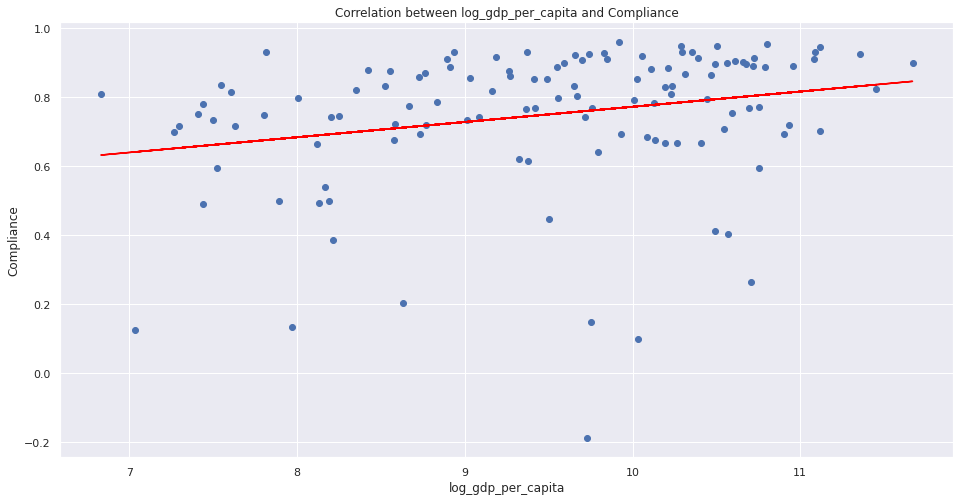

0.24405327179792635


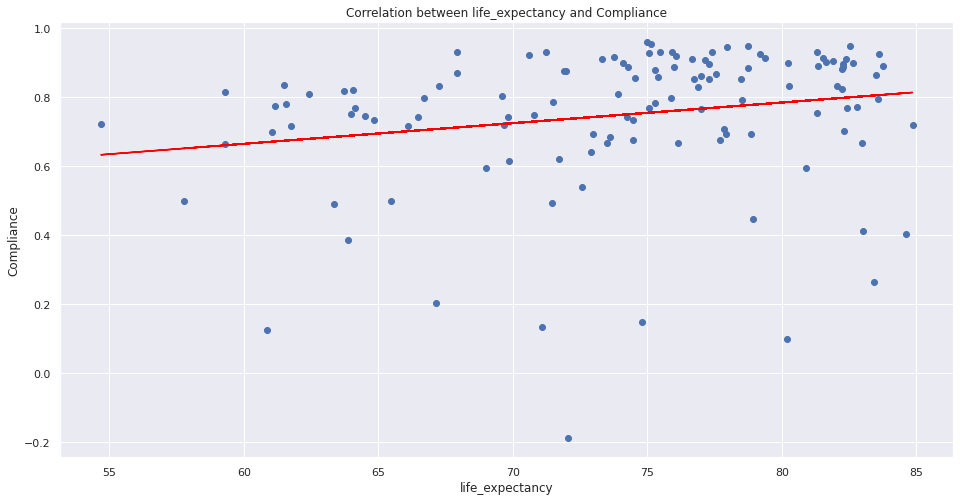

0.2051794927840709


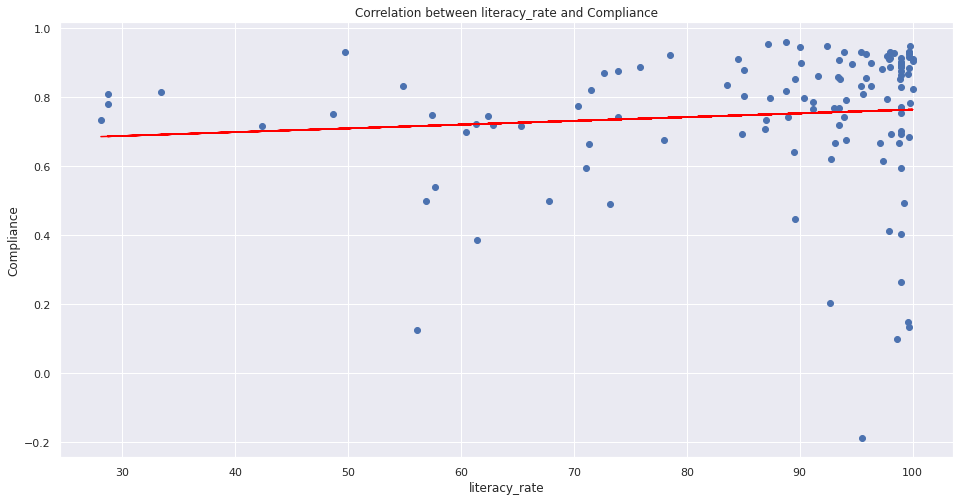

0.09231005707841579


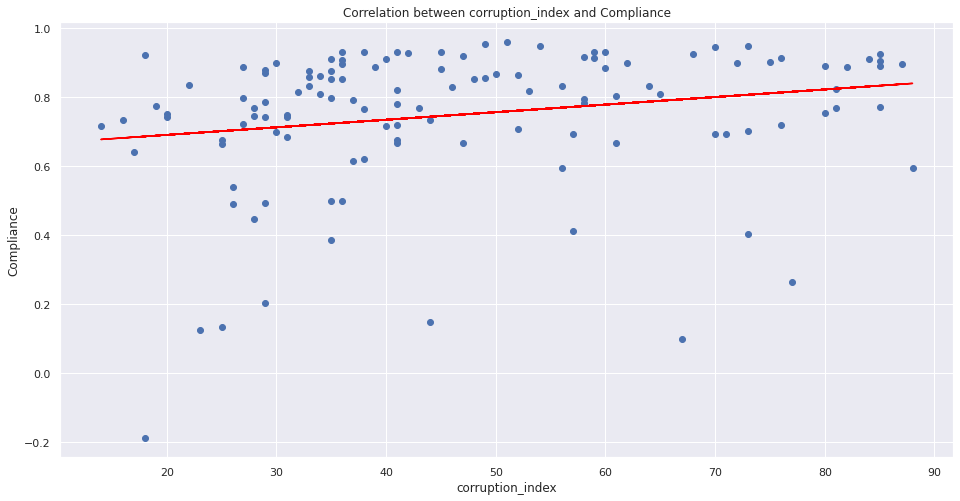

0.20953087257087927


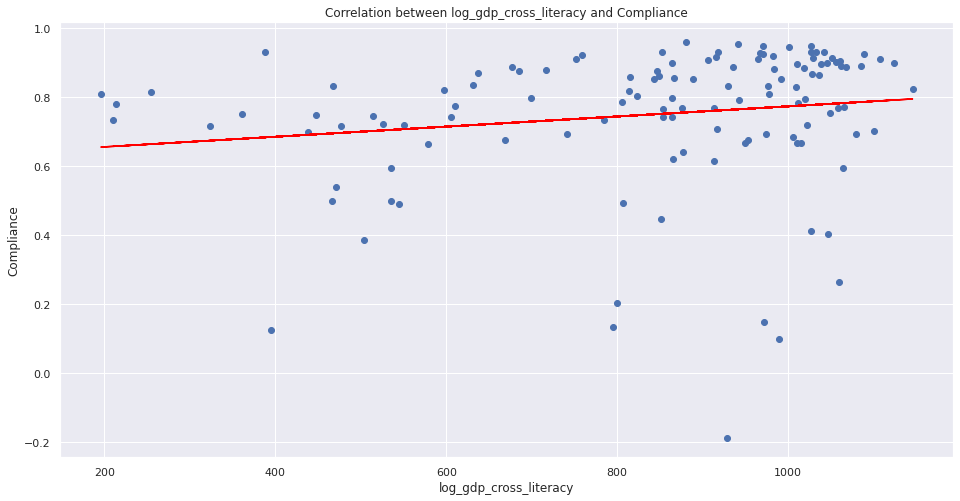

0.16482514338763923


In [ ]:
for feature in ['log_gdp_per_capita', 'life_expectancy', 'literacy_rate', 'corruption_index', 'log_gdp_cross_literacy']:
    x = compliance_df[feature]
    y = compliance_df['compilance']
    plt.scatter(x, y)
    a, b = np.polyfit(x, y, 1)
    plt.plot(x, a*x+b, color='red')
    plt.title('Correlation between {} and Compliance'.format(feature))
    plt.xlabel(feature)
    plt.ylabel('Compliance')
    plt.show()
    print(x.corr(y))

<AxesSubplot:>

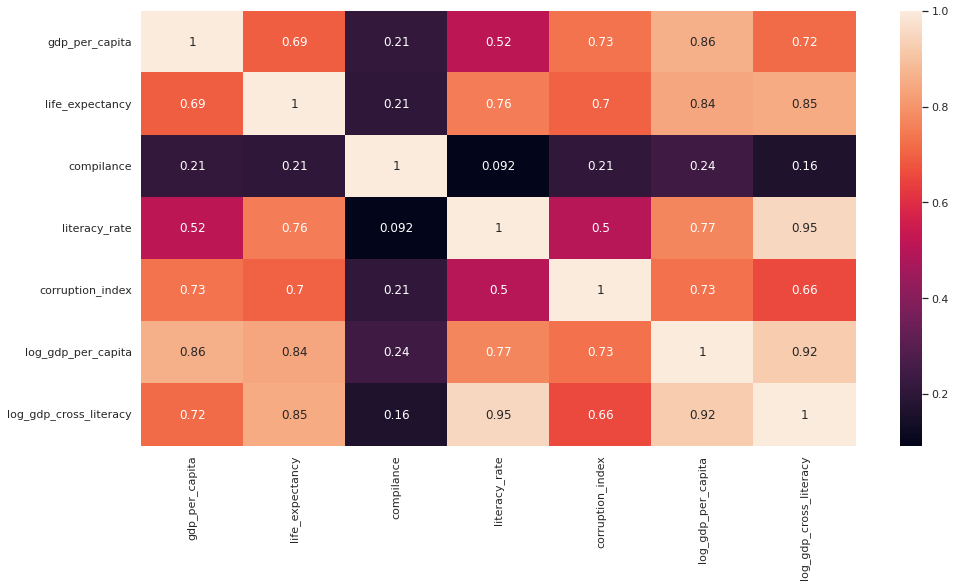

In [ ]:
sns.heatmap(compliance_df.corr(), annot=True)